In [13]:
import keras
features = ['active_rhythm', 'bass_line', 'entrance_effect', 'harmony', 'highest', 'in_chord', 'lowest', 'occurrence', 
   'onset_after_rest', 'rhythm_variety', 'strong_beats', 'sustained_rhythm', 'vertical_doubling']

In [14]:
from piano_reduction import tools as pr, compute_features as cf
from piano_reduction.score_data import ScoreData
import imp
imp.reload(pr)

<module 'piano_reduction.tools' from '/research/kevinyip12/ky1802/piano-reduction-main/piano_reduction/tools.py'>

In [15]:
features = ['active_rhythm', 'bass_line', 'entrance_effect', 'harmony', 'highest', 'in_chord', 'lowest', 'occurrence', 
   'onset_after_rest', 'rhythm_variety', 'strong_beats', 'sustained_rhythm', 'vertical_doubling']

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM, GRU
def dense():
    model2 = Sequential()
    model2.add(Dense(200, input_shape=(128, )))
    model2.add(Activation('sigmoid'))
    model2.add(Dropout(0.2))
    model2.add(Dense(128))
    model2.add(Activation('sigmoid'))
    model2.compile(optimizer='rmsprop',
                  loss='binary_crossentropy',
                  metrics=['accuracy', pr.f1])
    return model2

def dense_with_features():
    model2 = Sequential()
    model2.add(Dense(200, input_shape=(128 + 128 * len(features), )))
    model2.add(Activation('sigmoid'))
    model2.add(Dropout(0.2))
    model2.add(Dense(128))
    model2.add(Activation('sigmoid'))
    model2.compile(optimizer='rmsprop',
                  loss='binary_crossentropy',
                  metrics=['accuracy', pr.f1])
    return model2

def lstm():
    model2 = Sequential()
    model2.add(LSTM(200, input_shape=(None, 128)))
    model2.add(Activation('sigmoid'))
    model2.add(Dropout(0.2))
    model2.add(Dense(128))
    model2.add(Activation('sigmoid'))
    model2.compile(optimizer='rmsprop',
                  loss='binary_crossentropy',
                  metrics=['accuracy', pr.f1])
    return model2

def lstm_with_features():
    model2 = Sequential()
    model2.add(LSTM(200, input_shape=(None, 128 + 128 * len(features))))
    model2.add(Activation('sigmoid'))
    model2.add(Dropout(0.2))
    model2.add(Dense(128))
    model2.add(Activation('sigmoid'))
    model2.compile(optimizer='rmsprop',
                  loss='binary_crossentropy',
                  metrics=['accuracy', pr.f1])
    return model2
#model2.summary()

def gru():
    model2 = Sequential()
    model2.add(GRU(200, input_shape=(None, 128)))
    model2.add(Activation('sigmoid'))
    model2.add(Dropout(0.2))
    model2.add(Dense(128))
    model2.add(Activation('sigmoid'))
    model2.compile(optimizer='rmsprop',
                  loss='binary_crossentropy',
                  metrics=['accuracy', pr.f1])
    return model2
#model3.summary()

def gru_with_features():
    model2 = Sequential()
    model2.add(GRU(200, input_shape=(None, 128 + 128 * len(features))))
    model2.add(Activation('sigmoid'))
    model2.add(Dropout(0.2))
    model2.add(Dense(128))
    model2.add(Activation('sigmoid'))
    model2.compile(optimizer='rmsprop',
                  loss='binary_crossentropy',
                  metrics=['accuracy', pr.f1])
    return model2
#model4.summary()

def jaccard_similarity(y_train, y_pred):
    s = set()
    t = set()
    for i in range(0, len(y_train)):
        for j in range(0, 128):
            if y_train[i, j] == 1:
                t.add((i, j))
    for i in range(0, len(y_pred)):
        for j in range(0, 128):
            if y_pred[i, j] == 1:
                s.add((i, j))
    return len(s&t) * 1.0 / (len(s) + len(t) - len(s&t))

def pitch_class_jaccard_similarity(y_train, y_pred):
    s = set()
    t = set()
    for i in range(0, len(y_train)):
        for j in range(0, 128):
            if y_train[i, j] == 1:
                t.add((i, j % 12))
    for i in range(0, len(y_pred)):
        for j in range(0, 128):
            if y_pred[i, j] == 1:
                s.add((i, j % 12))
    return len(s&t) * 1.0 / (len(s) + len(t) - len(s&t))

In [4]:
def evaluate(model, testing_data, x_test, y_test, t=0.5):
    validation_data = testing_data.copy()
    validation_data = validation_data.merge_binary((model.predict(x_test) > t) * 1, skip_features=True)
    tmptrain = validation_data.to_binary('y_train')
    tmppred = validation_data.to_binary('y_pred')
    scores = []
    scores.append(jaccard_similarity(tmptrain, tmppred))
    scores.append(pitch_class_jaccard_similarity(tmptrain, tmppred))
    scores.append(metrics.accuracy_score(validation_data.df['y_train'], validation_data.df['y_pred']))
    scores.append(metrics.f1_score(validation_data.df['y_train'], validation_data.df['y_pred']))
    scores.append(metrics.roc_auc_score(tmptrain.flatten(), model.predict(x_test).flatten()))
    return scores

In [40]:
from sklearn import metrics
from collections import defaultdict
import numpy as np
testing_data = ScoreData.load('own_output/lr/2.pkl')

k = 5
display = 500
folds = data.kfold(k=k)
models = {}
models['NN'] = dense()
models['NN with features'] = dense_with_features()
models['LSTM'] = lstm()
models['LSTM with features'] = lstm_with_features()
models['GRU'] = gru()
models['GRU with features'] = gru_with_features()
print('%30s %20s %15s %15s %15s %15s' % ('', 'Jaccard Similarity', 'Ignore Octave', 'Accuracy', 'F1 score', 'roc_auc_score'))
avg = defaultdict(lambda : np.zeros(5))
for i in [3, 4, 5, 6, 9, 10]:
    training_data = ScoreData.load('score_data/%d.pkl' % i)
    print('Score = %d' % i)
    length = 10
    
    name = 'NN'
    model = models[name]
    x_train, y_train = training_data.generate_data_2(length=-1)
    x_test, y_test = testing_data.generate_data_2(length=-1)
    logger = pr.NBatchLogger(display=display)
    model.fit(x_train, y_train, epochs=500, batch_size=160, validation_data=(x_test, y_test), callbacks=[logger], verbose=0)
    x_train, y_train = training_data.generate_data_2(length=-1)
    x_test, y_test = testing_data.generate_data_2(length=-1)
    early_stop = pr.early_stop(patience=300)
    model.fit(x_train, y_train, epochs=2500, batch_size=160, validation_data=(x_test, y_test), callbacks=[logger, early_stop], verbose=0)
    scores = evaluate(model, testing_data, x_test, y_test)
    avg['%s with %d' % (name, length)] += np.array(scores)
    models[name] = model
    print('%30s %20.8f %15.8f %15.8f %15.8f %15.8f' % tuple(['%s with %d' % (name, length)] + scores))
    
    name = 'NN with features'
    model = models[name]
    x_train, y_train = training_data.generate_data_4(length=-1, features=features)
    x_test, y_test = testing_data.generate_data_4(length=-1, features=features)
    logger = pr.NBatchLogger(display=display)
    model.fit(x_train, y_train, epochs=500, batch_size=160, validation_data=(x_test, y_test), callbacks=[logger], verbose=0)
    x_train, y_train = training_data.generate_data_4(length=-1, features=features)
    x_test, y_test = testing_data.generate_data_4(length=-1, features=features)
    early_stop = pr.early_stop(patience=300)
    model.fit(x_train, y_train, epochs=2500, batch_size=160, validation_data=(x_test, y_test), callbacks=[logger, early_stop], verbose=0)
    scores = evaluate(model, testing_data, x_test, y_test)
    avg['%s with %d' % (name, length)] += np.array(scores)
    models[name] = model
    print('%30s %20.8f %15.8f %15.8f %15.8f %15.8f' % tuple(['%s with %d' % (name, length)] + scores))
    
    
    name = 'LSTM'
    model = models[name]
    x_train, y_train = training_data.generate_data_2(length=1)
    x_test, y_test = testing_data.generate_data_2(length=1)
    logger = pr.NBatchLogger(display=display)
    early_stop = pr.early_stop(patience=300)
    model.fit(x_train, y_train, epochs=3000, batch_size=160, validation_data=(x_test, y_test), callbacks=[logger, early_stop], verbose=0)
    x_train, y_train = training_data.generate_data_2(length=length)
    x_test, y_test = testing_data.generate_data_2(length=length)
    early_stop = pr.early_stop(patience=300)
    model.fit(x_train, y_train, epochs=2500, batch_size=160, validation_data=(x_test, y_test), callbacks=[logger, early_stop], verbose=0)
    scores = evaluate(model, testing_data, x_test, y_test)
    avg['%s with %d' % (name, length)] += np.array(scores)
    models[name] = model
    print('%30s %20.8f %15.8f %15.8f %15.8f %15.8f' % tuple(['%s with %d' % (name, length)] + scores))
    
    name = 'LSTM with features'
    model = models[name]
    x_train, y_train = training_data.generate_data_4(length=1, features=features)
    x_test, y_test = testing_data.generate_data_4(length=1, features=features)
    logger = pr.NBatchLogger(display=display)
    early_stop = pr.early_stop(patience=300)
    model.fit(x_train, y_train, epochs=3000, batch_size=160, validation_data=(x_test, y_test), callbacks=[logger, early_stop], verbose=0)
    early_stop = pr.early_stop(patience=300)
    x_train, y_train = training_data.generate_data_4(length=length, features=features)
    x_test, y_test = testing_data.generate_data_4(length=length, features=features)
    model.fit(x_train, y_train, epochs=2500, batch_size=160, validation_data=(x_test, y_test), callbacks=[logger, early_stop], verbose=0)
    scores = evaluate(model, testing_data, x_test, y_test)
    avg['%s with %d' % (name, length)] += np.array(scores)
    models[name] = model
    print('%30s %20.8f %15.8f %15.8f %15.8f %15.8f' % tuple(['%s with %d' % (name, length)] + scores))
    
    name = 'GRU'
    model = models[name]
    x_train, y_train = training_data.generate_data_2(length=1)
    x_test, y_test = testing_data.generate_data_2(length=1)
    logger = pr.NBatchLogger(display=display)
    early_stop = pr.early_stop(patience=300)
    model.fit(x_train, y_train, epochs=3000, batch_size=160, validation_data=(x_test, y_test), callbacks=[logger, early_stop], verbose=0)
    x_train, y_train = training_data.generate_data_2(length=length)
    x_test, y_test = testing_data.generate_data_2(length=length)
    early_stop = pr.early_stop(patience=300)
    model.fit(x_train, y_train, epochs=2500, batch_size=160, validation_data=(x_test, y_test), callbacks=[logger, early_stop], verbose=0)
    scores = evaluate(model, testing_data, x_test, y_test)
    avg['%s with %d' % (name, length)] += np.array(scores)
    models[name] = model
    print('%30s %20.8f %15.8f %15.8f %15.8f %15.8f' % tuple(['%s with %d' % (name, length)] + scores))
    
    name = 'GRU with features'
    model = models[name]
    x_train, y_train = training_data.generate_data_4(length=1, features=features)
    x_test, y_test = testing_data.generate_data_4(length=1, features=features)
    logger = pr.NBatchLogger(display=display)
    early_stop = pr.early_stop(patience=300)
    model.fit(x_train, y_train, epochs=3000, batch_size=160, validation_data=(x_test, y_test), callbacks=[logger, early_stop], verbose=0)
    early_stop = pr.early_stop(patience=300)
    x_train, y_train = training_data.generate_data_4(length=length, features=features)
    x_test, y_test = testing_data.generate_data_4(length=length, features=features)
    model.fit(x_train, y_train, epochs=2500, batch_size=160, validation_data=(x_test, y_test), callbacks=[logger, early_stop], verbose=0)
    scores = evaluate(model, testing_data, x_test, y_test)
    avg['%s with %d' % (name, length)] += np.array(scores)
    models[name] = model
    print('%30s %20.8f %15.8f %15.8f %15.8f %15.8f' % tuple(['%s with %d' % (name, length)] + scores))
    
print('Average :')
print('%30s %20s %15s %15s %15s %15s' % ('', 'Jaccard Similarity', 'Ignore Octave', 'Accuracy', 'F1 score', 'roc_auc_score'))
for name in avg:
    print('%30s %20.8f %15.8f %15.8f %15.8f %15.8f' % tuple([name] + list(avg[name] / k)))

                                 Jaccard Similarity   Ignore Octave        Accuracy        F1 score   roc_auc_score
Score = 3
step: 500/500 ...  - loss: 0.0239 - acc: 0.9918 - f1: 0.7128 - val_loss: 0.0913 - val_acc: 0.9821 - val_f1: 0.5058
                    NN with 10           0.40518519      0.59705489      0.48918575      0.57670005      0.88120931
step: 500/500 ...  - loss: 0.0084 - acc: 0.9975 - f1: 0.9205 - val_loss: 0.1180 - val_acc: 0.9819 - val_f1: 0.5145
      NN with features with 10           0.34811530      0.52763158      0.44771446      0.51644737      0.90087179
step: 500/3000 ...  - loss: 0.0317 - acc: 0.9891 - f1: 0.5721 - val_loss: 0.0985 - val_acc: 0.9784 - val_f1: 0.2892
step: 1000/3000 ...  - loss: 0.0193 - acc: 0.9930 - f1: 0.7812 - val_loss: 0.0923 - val_acc: 0.9807 - val_f1: 0.4458
step: 1500/3000 ...  - loss: 0.0176 - acc: 0.9937 - f1: 0.8054 - val_loss: 0.0953 - val_acc: 0.9813 - val_f1: 0.4769
step: 2000/2500 ...  - loss: 0.0153 - acc: 0.9945 - f1: 0.8322

In [33]:
from sklearn import metrics
from collections import defaultdict
import numpy as np
models = {}
display = 100
print('%30s %20s %15s %15s %15s %15s' % ('', 'Jaccard Similarity', 'Ignore Octave', 'Accuracy', 'F1 score', 'roc_auc_score'))
testing_data = ScoreData.load('score_data/2.pkl')
model_gru = gru()
model_gru_with_features = gru_with_features()
for i in range(3, 11):
    data = ScoreData.load('score_data/%d.pkl' % i)
    training_data = data
    length = 10
    
    name = 'GRU 3'
    model = model_gru
    x_train, y_train = training_data.generate_data_2(length=1)
    x_test, y_test = testing_data.generate_data_2(length=1)
    logger = pr.NBatchLogger(display=display)
    early_stop = pr.early_stop(patience=200)
    model.fit(x_train, y_train, epochs=1000, batch_size=160, validation_data=(x_test, y_test), callbacks=[logger, early_stop], verbose=0)
    early_stop = pr.early_stop(patience=200)
    x_train, y_train = training_data.generate_data_2(length=length)
    x_test, y_test = testing_data.generate_data_2(length=length)
    model.fit(x_train, y_train, epochs=2500, batch_size=160, validation_data=(x_test, y_test), callbacks=[logger, early_stop], verbose=0)
    scores = evaluate(model, testing_data, x_test, y_test)
    #avg['%s with %d' % (name, length)] += np.array(scores)
    models[name] = model
    print('%30s %20.8f %15.8f %15.8f %15.8f %15.8f' % tuple(['%s with %d' % (name, length)] + scores))
    
    name = 'GRU with features 3'
    model = model_gru_with_features
    x_train, y_train = training_data.generate_data_4(length=1, features=features)
    x_test, y_test = testing_data.generate_data_4(length=1, features=features)
    logger = pr.NBatchLogger(display=display)
    early_stop = pr.early_stop(patience=200)
    model.fit(x_train, y_train, epochs=1000, batch_size=160, validation_data=(x_test, y_test), callbacks=[logger, early_stop], verbose=0)
    early_stop = pr.early_stop(patience=200)
    x_train, y_train = training_data.generate_data_4(length=length, features=features)
    x_test, y_test = testing_data.generate_data_4(length=length, features=features)
    model.fit(x_train, y_train, epochs=2500, batch_size=160, validation_data=(x_test, y_test), callbacks=[logger, early_stop], verbose=0)
    scores = evaluate(model, testing_data, x_test, y_test)
    #avg['%s with %d' % (name, length)] += np.array(scores)
    models[name] = model
    print('%30s %20.8f %15.8f %15.8f %15.8f %15.8f' % tuple(['%s with %d' % (name, length)] + scores))
    
#print('Average :')
#print('%30s %20s %15s %15s %15s %15s' % ('', 'Jaccard Similarity', 'Ignore Octave', 'Accuracy', 'F1 score', 'roc_auc_score'))
#for name in avg:
#    print('%30s %20.8f %15.8f %15.8f %15.8f %15.8f' % tuple([name] + list(avg[name] / k)))

                                 Jaccard Similarity   Ignore Octave        Accuracy        F1 score   roc_auc_score
step: 100/1000 ...  - loss: 0.0537 - acc: 0.9837 - f1: 0.2246 - val_loss: 0.1001 - val_acc: 0.9790 - val_f1: 0.0441
step: 200/1000 ...  - loss: 0.0263 - acc: 0.9901 - f1: 0.6519 - val_loss: 0.0808 - val_acc: 0.9815 - val_f1: 0.3195
step: 300/1000 ...  - loss: 0.0218 - acc: 0.9920 - f1: 0.7428 - val_loss: 0.0814 - val_acc: 0.9824 - val_f1: 0.4136
step: 400/1000 ...  - loss: 0.0199 - acc: 0.9928 - f1: 0.7744 - val_loss: 0.0836 - val_acc: 0.9826 - val_f1: 0.4356
step: 500/1000 ...  - loss: 0.0186 - acc: 0.9933 - f1: 0.7926 - val_loss: 0.0857 - val_acc: 0.9827 - val_f1: 0.4448
step: 600/1000 ...  - loss: 0.0177 - acc: 0.9937 - f1: 0.8053 - val_loss: 0.0877 - val_acc: 0.9828 - val_f1: 0.4540
step: 700/1000 ...  - loss: 0.0170 - acc: 0.9939 - f1: 0.8138 - val_loss: 0.0895 - val_acc: 0.9828 - val_f1: 0.4542
step: 800/2500 ...  - loss: 0.0155 - acc: 0.9945 - f1: 0.8319 - val_loss

In [41]:
print('%30s %20s %15s %15s %15s %15s' % ('', 'Jaccard Similarity', 'Ignore Octave', 'Accuracy', 'F1 score', 'roc_auc_score'))
import matplotlib.pyplot as plt
from tqdm import tqdm
score = [[[] for _ in range(6)] for _ in range(5)]
xa = []
length = -1

for T in tqdm(range(1, 50)):
    t = 0.0 + 1.0 * T / 50
    xa.append(t)
    length = -1
    name = 'NN'
    #x_train, y_train = training_data.generate_data_2(length=length)
    x_test, y_test = testing_data.generate_data_2(length=length)
    scores = evaluate(models[name], testing_data, x_test, y_test, t=t)
    for i in range(5):
        score[i][0].append(scores[i])
    
    name = 'NN with features'
    #x_train, y_train = training_data.generate_data_4(length=length, features=features)
    x_test, y_test = testing_data.generate_data_4(length=length, features=features)
    scores = evaluate(models[name], testing_data, x_test, y_test, t=t)
    for i in range(5):
        score[i][1].append(scores[i])
    
    length = 10
    name = 'LSTM'
    #x_train, y_train = training_data.generate_data_2(length=length)
    x_test, y_test = testing_data.generate_data_2(length=length)
    scores = evaluate(models[name], testing_data, x_test, y_test, t=t)
    for i in range(5):
        score[i][2].append(scores[i])
    
    name = 'LSTM with features'
    #x_train, y_train = training_data.generate_data_4(length=length, features=features)
    x_test, y_test = testing_data.generate_data_4(length=length, features=features)
    scores = evaluate(models[name], testing_data, x_test, y_test, t=t)
    for i in range(5):
        score[i][3].append(scores[i])
    
    name = 'GRU'
    #x_train, y_train = training_data.generate_data_2(length=length)
    x_test, y_test = testing_data.generate_data_2(length=length)
    scores = evaluate(models[name], testing_data, x_test, y_test, t=t)
    for i in range(5):
        score[i][4].append(scores[i])
    
    name = 'GRU with features'
    #x_train, y_train = training_data.generate_data_4(length=length, features=features)
    x_test, y_test = testing_data.generate_data_4(length=length, features=features)
    scores = evaluate(models[name], testing_data, x_test, y_test, t=t)
    for i in range(5):
        score[i][5].append(scores[i])

    #print('%30s %20.8f %15.8f %15.8f %15.8f %15.8f' % tuple(['%s with %d' % (name, length)] + scores))


  0%|          | 0/49 [00:00<?, ?it/s]

                                 Jaccard Similarity   Ignore Octave        Accuracy        F1 score   roc_auc_score



100%|██████████| 49/49 [11:12<00:00, 11.40s/it]


In [35]:
print('%30s %20s %15s %15s %15s %15s' % ('', 'Jaccard Similarity', 'Ignore Octave', 'Accuracy', 'F1 score', 'roc_auc_score'))
import matplotlib.pyplot as plt
from tqdm import tqdm
score = [[[] for _ in range(6)] for _ in range(5)]
xa = []
length = -1

for T in tqdm(range(1, 50)):
    t = 0.0 + 1.0 * T / 50
    xa.append(t)
    
    length = 10
    
    name = 'GRU 3'
    x_train, y_train = training_data.generate_data_2(length=length)
    x_test, y_test = testing_data.generate_data_2(length=length)
    scores = evaluate(models[name], testing_data, x_test, y_test, t=t)
    for i in range(5):
        score[i][4].append(scores[i])
        
    name = 'GRU with features 3'
    x_train, y_train = training_data.generate_data_4(length=length, features=features)
    x_test, y_test = testing_data.generate_data_4(length=length, features=features)
    scores = evaluate(models[name], testing_data, x_test, y_test, t=t)
    for i in range(5):
        score[i][5].append(scores[i])

    #print('%30s %20.8f %15.8f %15.8f %15.8f %15.8f' % tuple(['%s with %d' % (name, length)] + scores))


  0%|          | 0/49 [00:00<?, ?it/s]

                                 Jaccard Similarity   Ignore Octave        Accuracy        F1 score   roc_auc_score



100%|██████████| 49/49 [10:44<00:00, 11.90s/it]


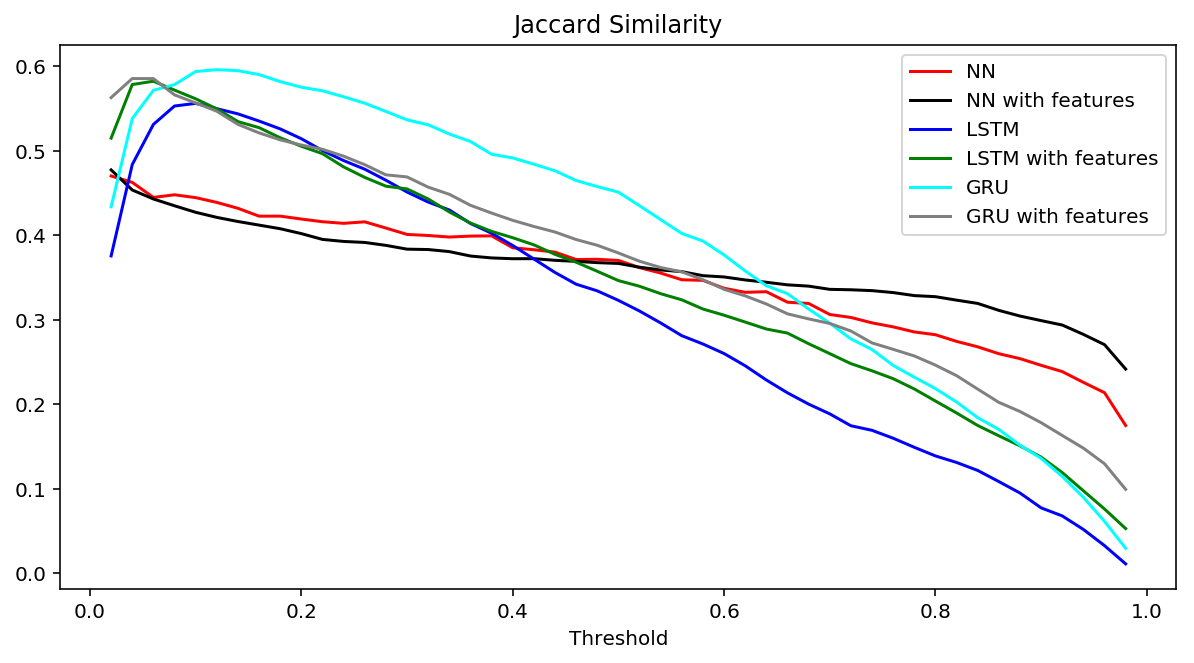

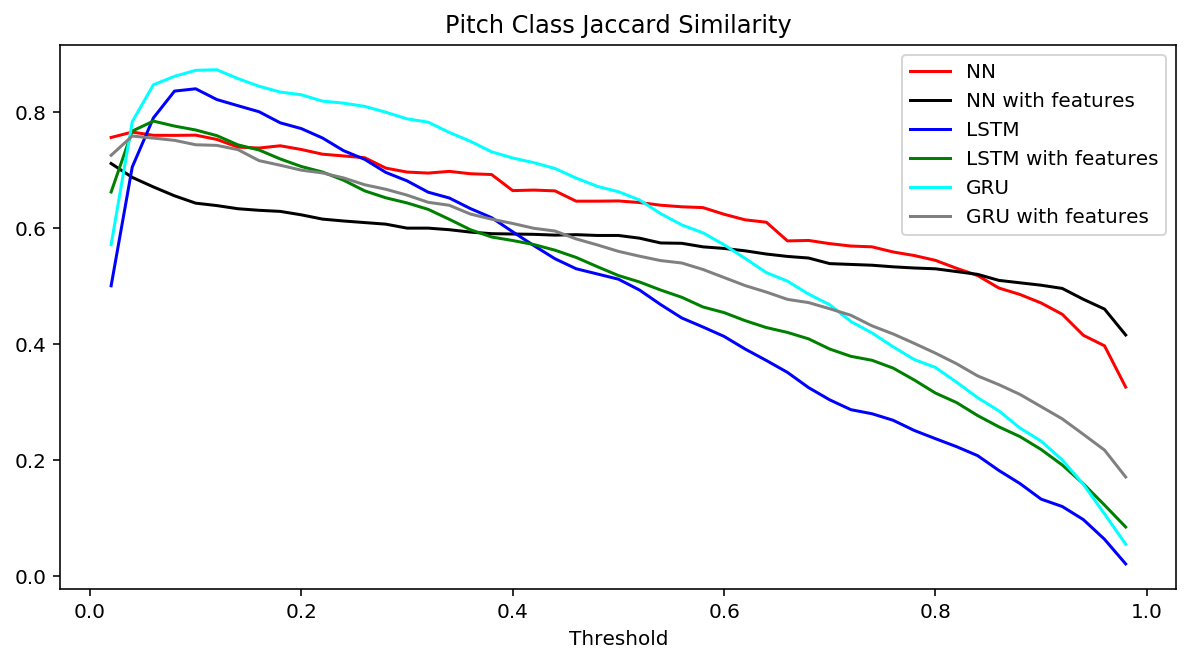

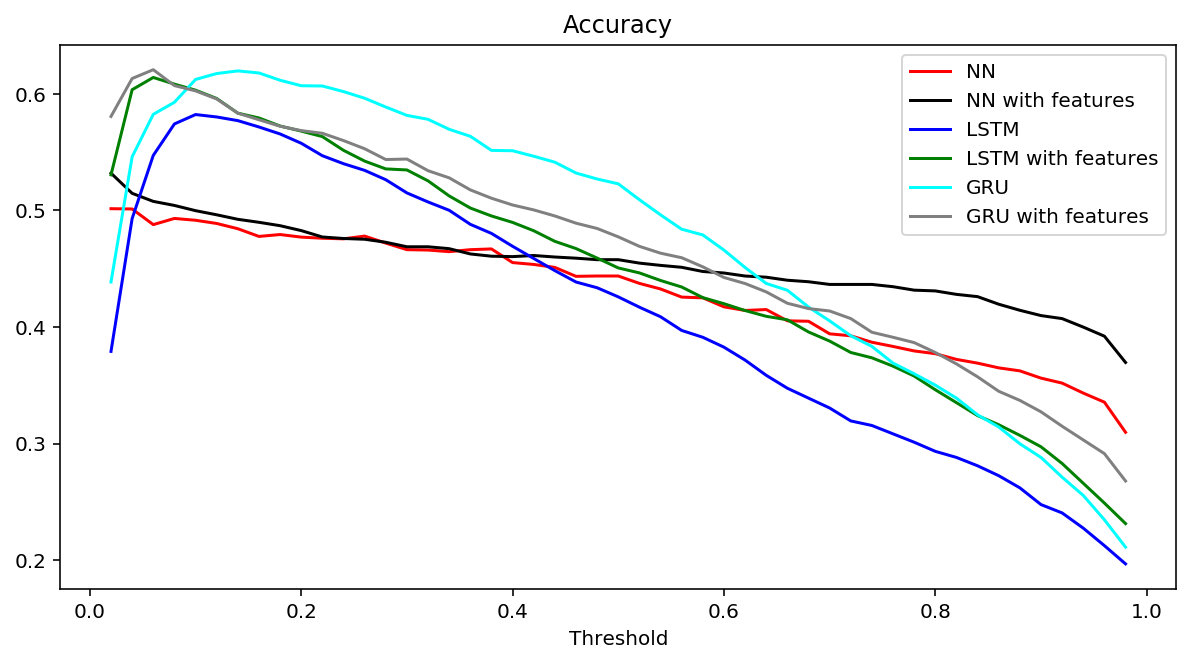

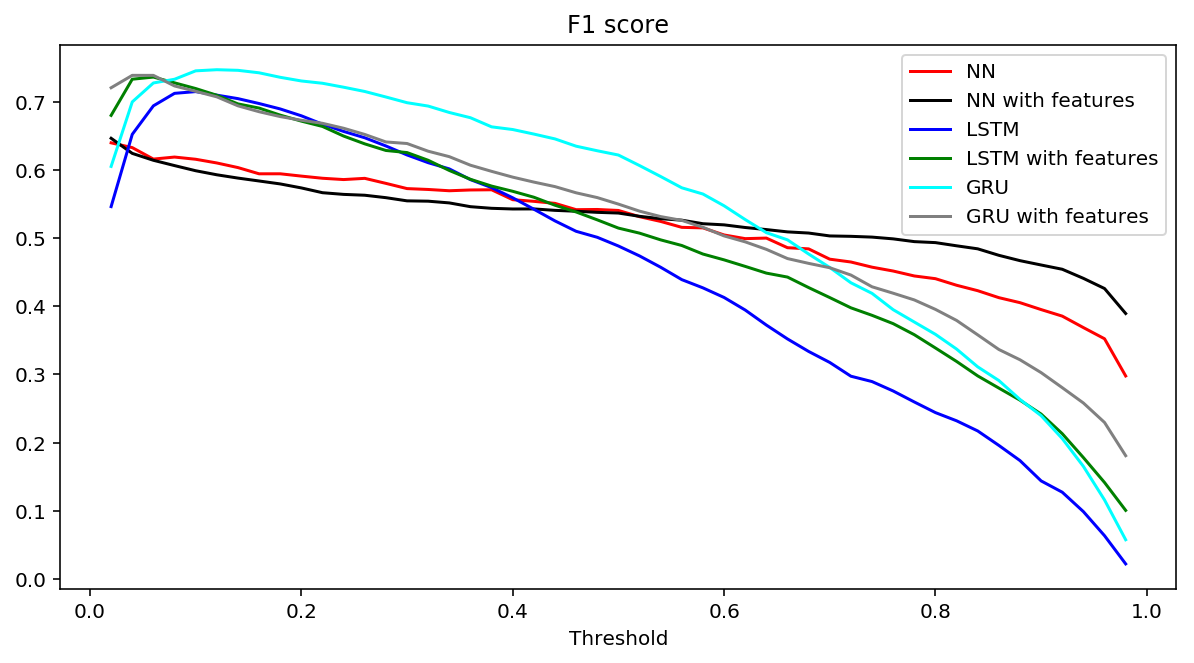

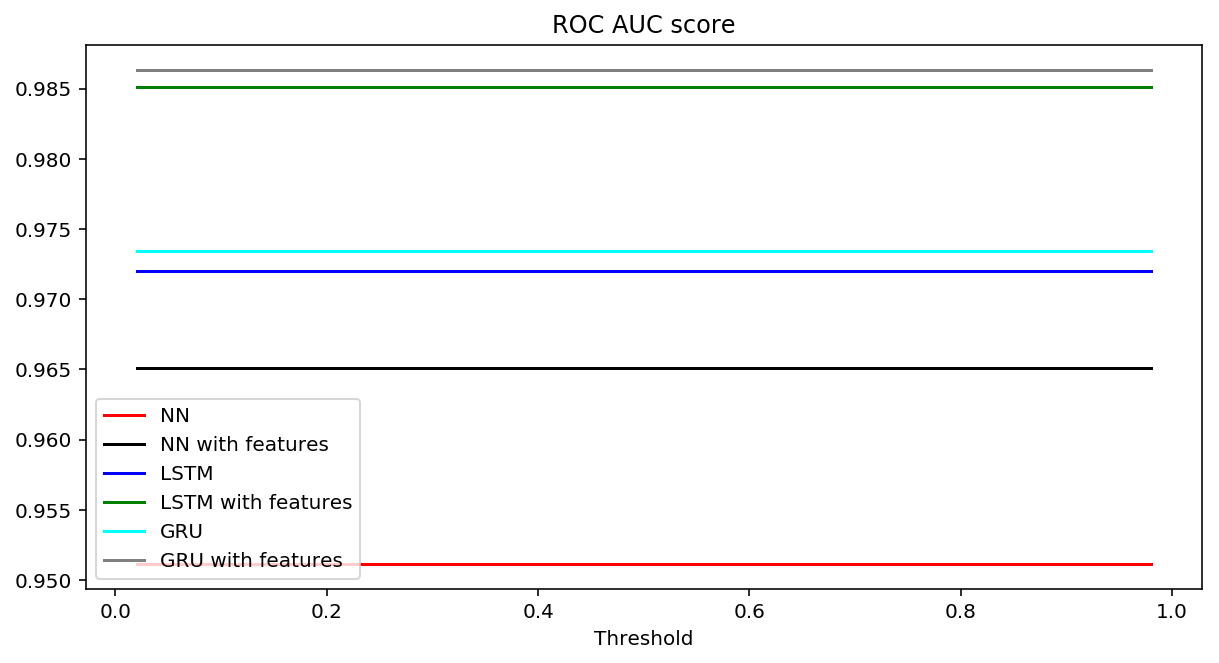

In [43]:
metrics = ['Jaccard Similarity', 'Pitch Class Jaccard Similarity', 'Accuracy', 'F1 score', 'ROC AUC score']
for Z in range(5):
    plt.figure(figsize=(10, 5))
    plt.plot(xa, score[Z][0], c='red', label='NN') # NN
    plt.plot(xa, score[Z][1], c='black', label='NN with features') # NN with features
    plt.plot(xa, score[Z][2], c='blue', label='LSTM') # LSTM
    plt.plot(xa, score[Z][3], c='green', label='LSTM with features') # LSTM with features
    plt.plot(xa, score[Z][4], c='cyan', label='GRU') # GRU
    plt.plot(xa, score[Z][5], c='grey', label='GRU with features') # GRU with features
    plt.legend()
    plt.title(metrics[Z])
    plt.xlabel('Threshold')
    plt.savefig('graphs/%s_2.png' % metrics[Z].replace(' ', '_'))
    plt.show()

In [44]:
for i in range(6):
    print(score[4][i][0])

0.9511436782152689
0.9650616296621177
0.972017474424736
0.9851146881592856
0.973463969797602
0.9863432431011727


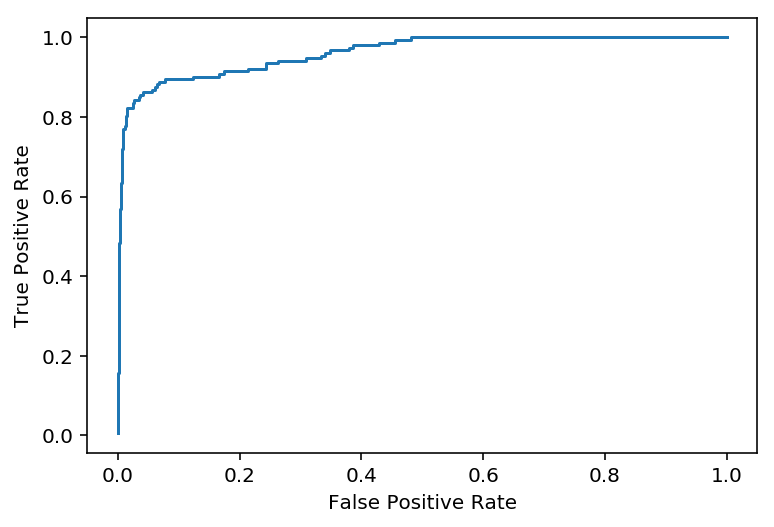

In [58]:
from sklearn.metrics import roc_curve
x_test, y_test = testing_data.generate_data_4(length=length, features=features)
x, y, _ = roc_curve(y_test.flatten(), models['GRU with features'].predict(x_test).flatten())
plt.plot(x, y)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()
#for i in range(x.shape[0]):
#    print(x[i], y[i], _[i])

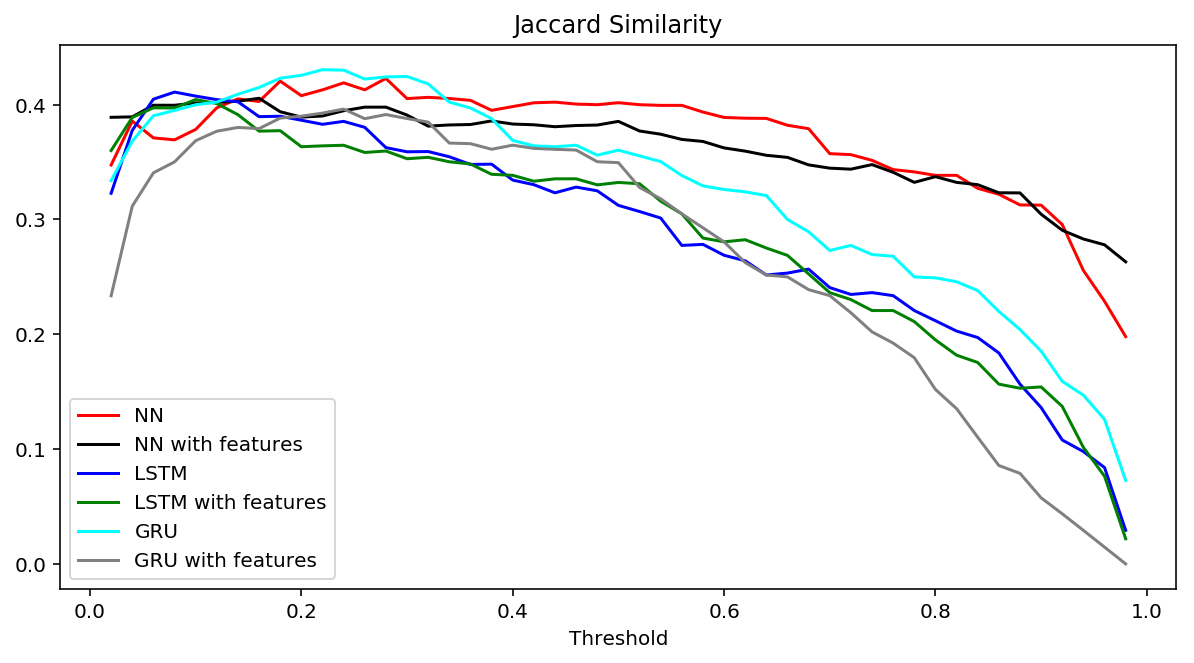

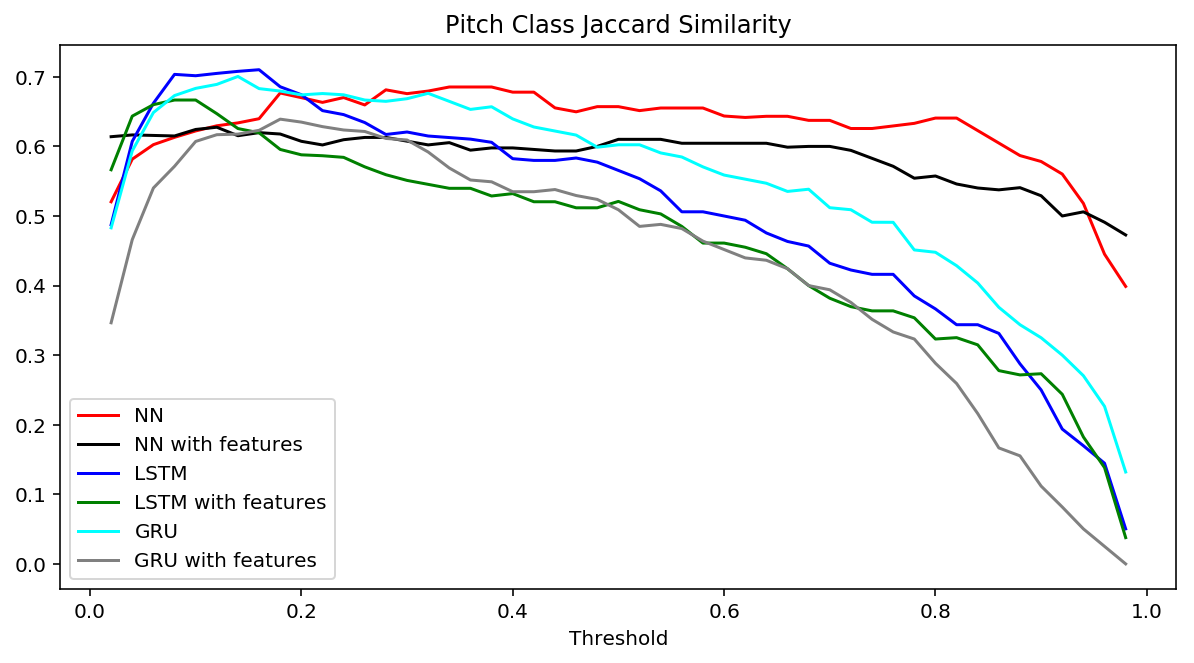

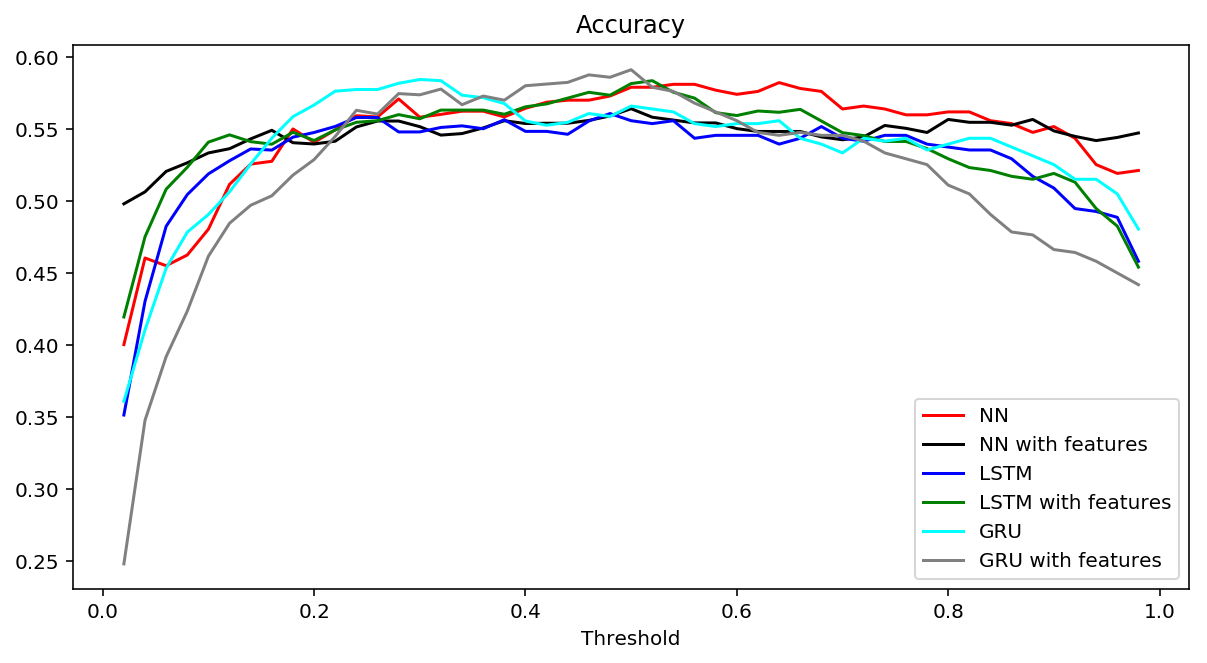

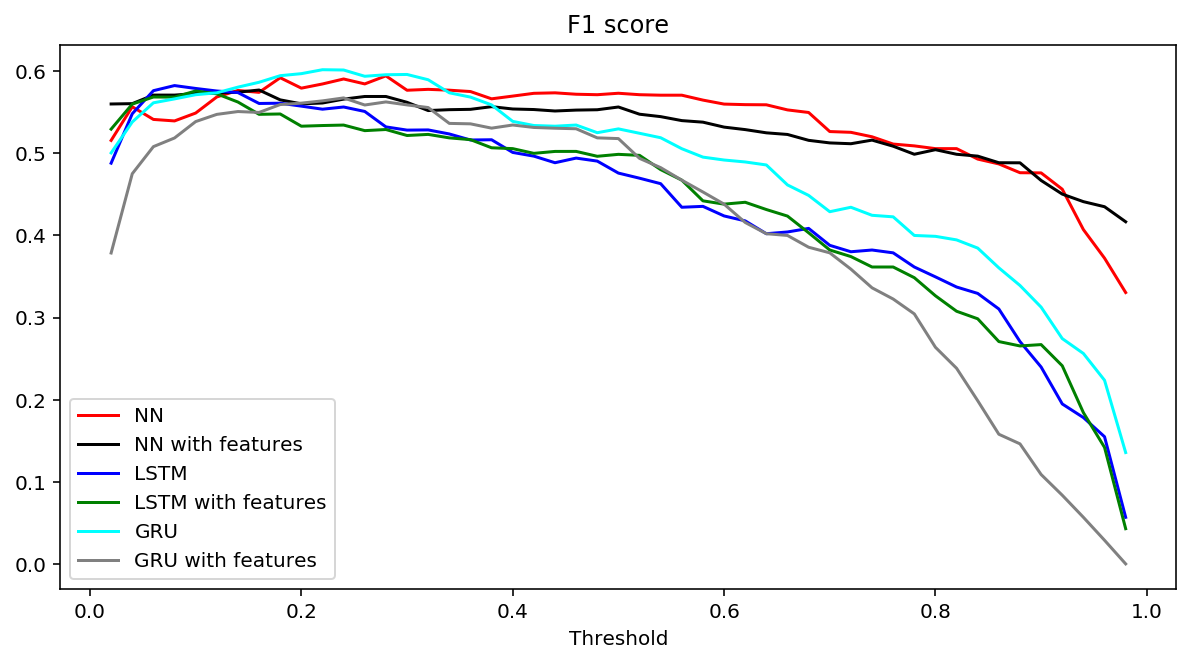

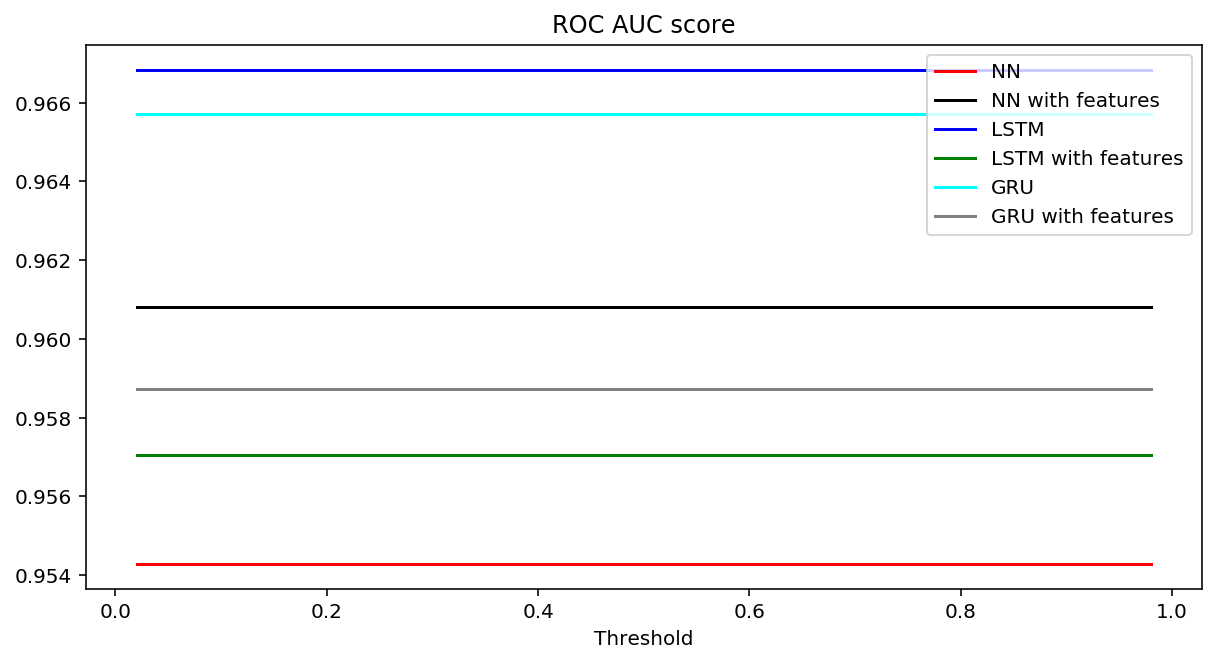

In [116]:
metrics = ['Jaccard Similarity', 'Pitch Class Jaccard Similarity', 'Accuracy', 'F1 score', 'ROC AUC score']
for Z in range(5):
    plt.figure(figsize=(10, 5))
    plt.plot(xa, score[Z][0], c='red', label='NN') # NN
    plt.plot(xa, score[Z][1], c='black', label='NN with features') # NN with features
    plt.plot(xa, score[Z][2], c='blue', label='LSTM') # LSTM
    plt.plot(xa, score[Z][3], c='green', label='LSTM with features') # LSTM with features
    plt.plot(xa, score[Z][4], c='cyan', label='GRU') # GRU
    plt.plot(xa, score[Z][5], c='grey', label='GRU with features') # GRU with features
    plt.legend()
    plt.title(metrics[Z])
    plt.xlabel('Threshold')
    plt.savefig('graphs/%s.png' % metrics[Z].replace(' ', '_'))
    plt.show()

In [45]:
for name in models:
    models[name].save('models/20181127/%s_2.h5' % name)

In [ ]:
def nn():
    model2 = Sequential()
    model2.add(Dense(128, input_shape=(None, 128)))
    model2.add(Dropout(0.2))
    model2.add(Activation('sigmoid'))
    model2.compile(optimizer='rmsprop',
                  loss='binary_crossentropy',
                  metrics=['accuracy', pr.f1])
    return model2

In [59]:
print('Average :')
for name in avg:
    print('%30s %20.8f %15.8f %15.8f %15.8f %15.8f' % tuple([name] + list(avg[name] / k)))

Average :
                    GRU with 5           0.09459005      0.14380711      0.36003136      0.16637830      0.62201370
      GRU with features with 5           0.30460336      0.48158890      0.46024081      0.46161298      0.82007194


In [ ]:
from random import randint
data = ScoreData.load('score_data/3.pkl')

for _ in range(10):
    length = randint(1, 6)
    if _ == 0:
        length = 1
    length = _ + 1
    key = randint(-12, 12)
    testing_data, training_data = data.split()
    training_data.df['ps'] -= key
    print('length = %d, key = %d' % (length, key))
    
    x_train, y_train = training_data.generate_data_2(length=length)
    x_test, y_test = testing_data.generate_data_2(length=length)
    logger = pr.NBatchLogger(display=50)
    #early_stop = pr.early_stop(patience=20)
    model3.fit(x_train, y_train, epochs=300, batch_size=16, validation_data=(x_test, y_test), callbacks=[logger], verbose=0)
    
    x_train, y_train = training_data.generate_data_4(length=length, features=features)
    x_test, y_test = testing_data.generate_data_4(length=length, features=features)
    logger = pr.NBatchLogger(display=50)
    #early_stop = pr.early_stop(patience=20)
    model4.fit(x_train, y_train, epochs=300, batch_size=16, validation_data=(x_test, y_test), callbacks=[logger], verbose=0)

In [13]:
data = ScoreData.load('score_data/3.pkl')
data = data.merge_binary((model4.predict(data.generate_data_4(length=5, features=features)[0]) > 0.5) * 1, skip_features=True)
data.save('result/3_gru_feature.pkl')

In [5]:
from keras.models import load_model
model4 = load_model('models/gru_42.h5', custom_objects={'f1': pr.f1})

In [47]:
model4.save('models/gru_42.h5')

In [9]:
from sklearn import metrics
import numpy as np
data = ScoreData.load('score_data/2.pkl')
name = 'GRU 2'
model = gru()
display = 100
training_data = data
length = 10
for key in range(-12, 13):
    training_data = data.copy()
    training_data.df['ps'] -= key
    training_data.df['ps'] = training_data.df['ps'].apply(lambda x: 0 if x < 0 else (127 if x > 127 else x))
    testing_data = ScoreData.load('score_data/3.pkl')
    x_train, y_train = training_data.generate_data_2(length=1)
    x_test, y_test = testing_data.generate_data_2(length=1)
    logger = pr.NBatchLogger(display=display)
    early_stop = pr.early_stop(patience=300)
    model.fit(x_train, y_train, epochs=1000, batch_size=160, validation_data=(x_test, y_test), callbacks=[logger, early_stop], verbose=0)
    x_train, y_train = training_data.generate_data_2(length=length)
    x_test, y_test = testing_data.generate_data_2(length=length)
    early_stop = pr.early_stop(patience=300)
    model.fit(x_train, y_train, epochs=2500, batch_size=160, validation_data=(x_test, y_test), callbacks=[logger, early_stop], verbose=0)
    scores = evaluate(model, testing_data, x_test, y_test)
    #avg['%s with %d' % (name, length)] += np.array(scores)
    models[name] = model
    print('%30s %20.8f %15.8f %15.8f %15.8f %15.8f' % tuple(['%s with %d' % (name, length)] + scores))

step: 100/1000 ...  - loss: 0.0955 - acc: 0.9735 - f1: 0.0051 - val_loss: 0.1186 - val_acc: 0.9814 - val_f1: 1.8549e-04
step: 200/1000 ...  - loss: 0.0532 - acc: 0.9809 - f1: 0.2172 - val_loss: 0.1148 - val_acc: 0.9828 - val_f1: 0.0094
step: 300/1000 ...  - loss: 0.0397 - acc: 0.9849 - f1: 0.4947 - val_loss: 0.1097 - val_acc: 0.9828 - val_f1: 0.0617
step: 400/1000 ...  - loss: 0.0315 - acc: 0.9881 - f1: 0.6504 - val_loss: 0.1069 - val_acc: 0.9830 - val_f1: 0.1486
step: 500/1000 ...  - loss: 0.0264 - acc: 0.9903 - f1: 0.7329 - val_loss: 0.1066 - val_acc: 0.9832 - val_f1: 0.2093
step: 600/1000 ...  - loss: 0.0229 - acc: 0.9917 - f1: 0.7810 - val_loss: 0.1077 - val_acc: 0.9832 - val_f1: 0.2270
step: 700/1000 ...  - loss: 0.0205 - acc: 0.9927 - f1: 0.8126 - val_loss: 0.1092 - val_acc: 0.9832 - val_f1: 0.2441
step: 800/2500 ...  - loss: 0.0199 - acc: 0.9930 - f1: 0.8166 - val_loss: 0.1091 - val_acc: 0.9831 - val_f1: 0.2374
step: 900/2500 ...  - loss: 0.0141 - acc: 0.9959 - f1: 0.8958 - val_

KeyboardInterrupt: 

In [7]:
data = ScoreData.load('score_data/3.pkl')
data.to_binary_3('x_train').shape

(1658, 2048)

In [3]:
data = ScoreData.load('score_data/2.pkl')
data.df.columns

Index(['measure', 'offset', 'part', 'ps', 'tie', 'x_train', 'color', 'y_train',
       'duration', 'pitch', 'active_rhythm', 'bass_line', 'entrance_effect',
       'harmony', 'highest', 'in_chord', 'lowest', 'occurrence',
       'offset_value', 'onset_after_rest', 'pitch_distance', 'rhythm_variety',
       'strong_beats', 'sustained_rhythm', 'vertical_doubling'],
      dtype='object')

In [7]:
for i, row in data.df.iterrows():
    r = row
    break


In [50]:
data = ScoreData.load('score_data/2.pkl')
((model4.predict(validation_data.generate_data_4(length=8)[0])) * 1)[-2]

array([0.7310586 , 0.26894143, 0.27391064, 0.3355228 , 0.7303054 ,
       0.2821237 , 0.7310586 , 0.73089325, 0.26894143, 0.26894143,
       0.26894143, 0.26894143, 0.26901832, 0.26894143, 0.3643404 ,
       0.26894233, 0.26894143, 0.27013814, 0.26894143, 0.7310586 ,
       0.26894143, 0.26894143, 0.7310586 , 0.26894143, 0.67148846,
       0.26894143, 0.26894143, 0.26894143, 0.26894143, 0.26894143,
       0.26894143, 0.7310586 , 0.7310586 , 0.26894143, 0.26894143,
       0.26894143, 0.7310586 , 0.26894143, 0.26894143, 0.26894143,
       0.7310578 , 0.7310586 , 0.26894143, 0.28520656, 0.72980475,
       0.26894143, 0.27105495, 0.26894143, 0.2689641 , 0.7310586 ,
       0.26894143, 0.26894143, 0.26894143, 0.26894143, 0.26894143,
       0.7310586 , 0.26894143, 0.26894143, 0.7310586 , 0.27316225,
       0.26894143, 0.26894143, 0.26894143, 0.26894143, 0.26894143,
       0.7310207 , 0.26894143, 0.29600608, 0.26894143, 0.2689415 ,
       0.26894143, 0.73052543, 0.26894143, 0.26894143, 0.73105

In [34]:
validation_data.generate_data_4(length=1)[1][-2].astype(int)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [20]:
validation_data.generate_data_4(length=2)[0].shape

(378, 2, 2048)

In [6]:
names = ['NN', 'NN with features', 'LSTM', 'LSTM with features', 'GRU', 'GRU with features']
from keras.models import load_model
models = {}
for name in names:
    models[name] = load_model('models/20181127/%s.h5' % name, custom_objects={'f1': pr.f1})

In [56]:
testing_data = ScoreData.load('score_data/0.pkl')
#x_test, y_test = testing_data.generate_data_4(length=10, features=features)
#validation_data = testing_data.copy()
#validation_data = validation_data.merge_binary((models['GRU with features'].predict(x_test) > 0.3) * 1, skip_features=True)
#validation_data.save('result/2_gru_with_features.pkl')

#x_test, y_test = testing_data.generate_data_4(length=10, features=features)
#validation_data = testing_data.copy()
#validation_data = validation_data.merge_binary((models['GRU with features 3'].predict(x_test) > 0.2) * 1, skip_features=True)
#validation_data.save('result/2_gru3.pkl')

x_test, y_test = testing_data.generate_data_2(length=10)
validation_data = testing_data.copy()
validation_data = validation_data.merge_binary((models['GRU'].predict(x_test) > 0.1) * 1, skip_features=True)
validation_data.save('result/0_gru3.pkl')

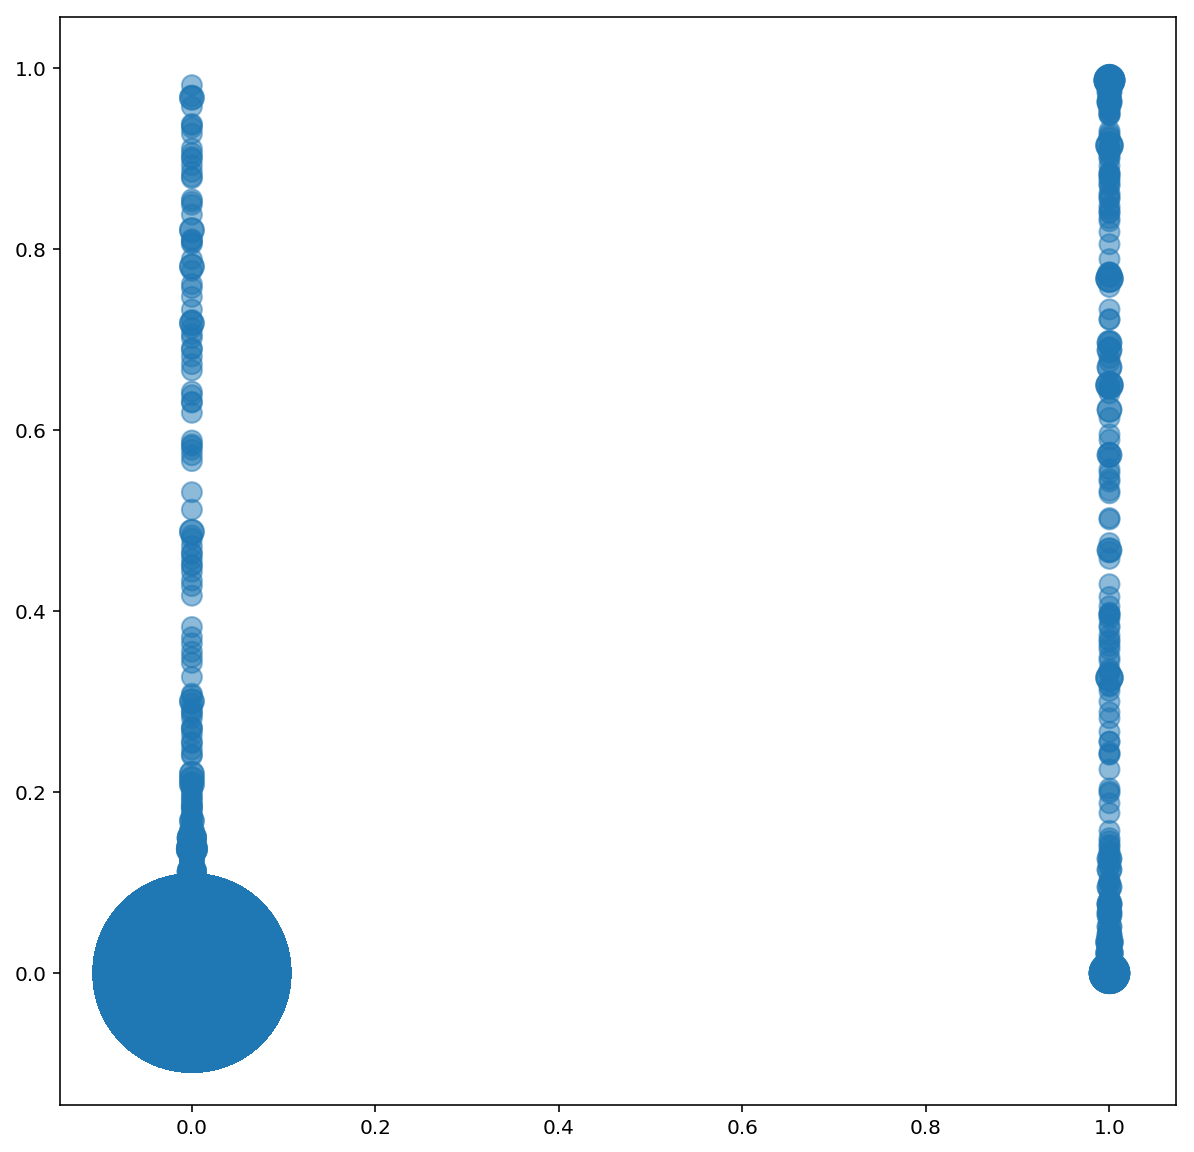

In [164]:
from collections import Counter
import math
def f(x):
    return int(x * 1000)
training_data, testing_data = ScoreData.load('score_data/2.pkl').kfold(k=5)[4]
x_test, y_test = testing_data.generate_data_2(length=10)
y_pred = models['GRU'].predict(x_test)
y_test = list(y_test.flatten())
y_pred = list(y_pred.flatten())
c = Counter(zip(y_test, list(map(f, y_pred))))
plt.figure(figsize=(10, 10))
s = [math.sqrt(c[(xx,yy)]) * 100 for xx,yy in zip(y_test, list(map(f, y_pred)))]
plt.scatter(y_test, y_pred, s=s, alpha=0.5)
plt.show()

In [12]:
def jaccard_similarity(y_train, y_pred):
    s = set()
    t = set()
    for i in range(0, len(y_train)):
        for j in range(0, 128):
            if y_train[i, j] == 1:
                t.add((i, j))
    for i in range(0, len(y_pred)):
        for j in range(0, 128):
            if y_pred[i, j] == 1:
                s.add((i, j))
    return len(s&t) * 1.0 / (len(s) + len(t) - len(s&t))

def pitch_class_jaccard_similarity(y_train, y_pred):
    s = set()
    t = set()
    for i in range(0, len(y_train)):
        for j in range(0, 128):
            if y_train[i, j] == 1:
                t.add((i, j % 12))
    for i in range(0, len(y_pred)):
        for j in range(0, 128):
            if y_pred[i, j] == 1:
                s.add((i, j % 12))
    return len(s&t) * 1.0 / (len(s) + len(t) - len(s&t))

In [14]:
-0.1 < data.df['measure']

0       True
1       True
2       True
3       True
4       True
5       True
6       True
7       True
8       True
9       True
10      True
11      True
12      True
13      True
14      True
15      True
16      True
17      True
18      True
19      True
20      True
21      True
22      True
23      True
24      True
25      True
26      True
27      True
28      True
29      True
        ... 
1666    True
1508    True
1509    True
1510    True
1511    True
1512    True
1513    True
1514    True
1515    True
1516    True
1667    True
1517    True
1518    True
1519    True
1520    True
1521    True
1522    True
1523    True
1524    True
1525    True
1668    True
1526    True
1527    True
1528    True
1529    True
1530    True
1531    True
1532    True
1669    True
1533    True
Name: measure, Length: 1670, dtype: bool

In [ ]:
x = [[7, 4, 3],
     [4, 1, 8],
     [6, 3, 5],
     [8, 6, 1],
     [8, 5, 7],
     [7, 2, 9],
     [5, 3, 3],
     [9, 5, 8],
     [7, 4, 5],
     [8, 2, 2]]